# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
from gan.train import train
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## MNIST Dataset


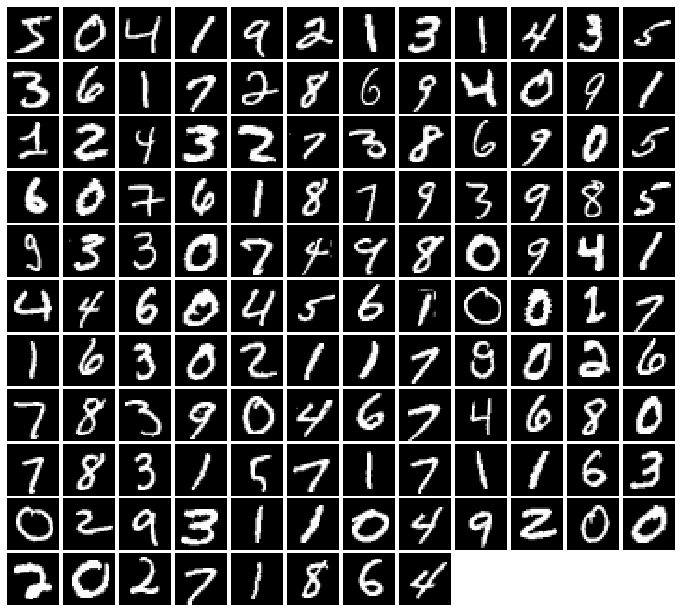

In [4]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

# Discriminator and Generator


In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


In [6]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

In [7]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="files/gan_samples/mnist.jpg" width=500>

EPOCH:  1
Iter: 0, D: 1.427, G:0.6891


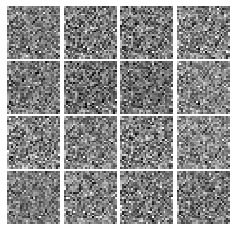


Iter: 250, D: 1.244, G:0.8414


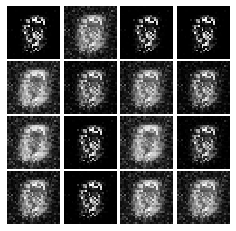


EPOCH:  2
Iter: 500, D: 0.7878, G:1.586


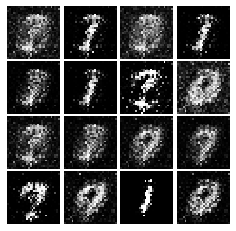


Iter: 750, D: 1.108, G:1.339


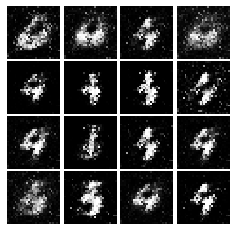


EPOCH:  3
Iter: 1000, D: 1.133, G:1.222


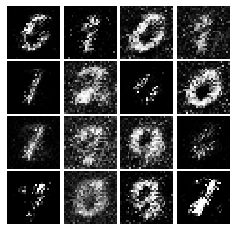


Iter: 1250, D: 1.292, G:1.095


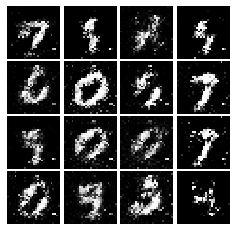


EPOCH:  4
Iter: 1500, D: 0.9698, G:1.18


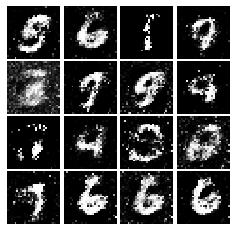


Iter: 1750, D: 0.9947, G:0.9984


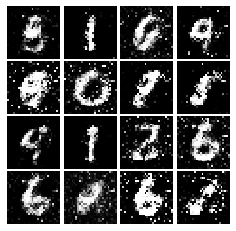


EPOCH:  5
Iter: 2000, D: 1.192, G:0.9431


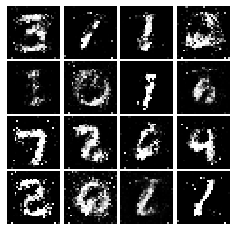


Iter: 2250, D: 1.177, G:0.9138


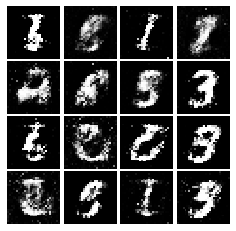


EPOCH:  6
Iter: 2500, D: 1.265, G:1.028


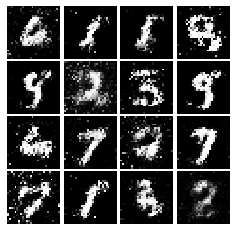


Iter: 2750, D: 1.365, G:0.8478


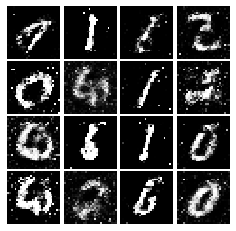


EPOCH:  7
Iter: 3000, D: 1.263, G:0.9503


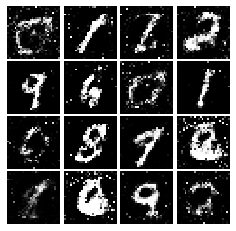


Iter: 3250, D: 1.238, G:0.8606


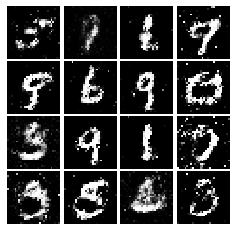


EPOCH:  8
Iter: 3500, D: 1.331, G:0.842


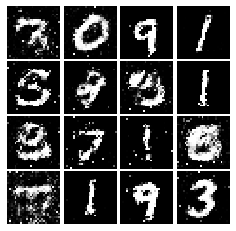


EPOCH:  9
Iter: 3750, D: 1.25, G:0.8746


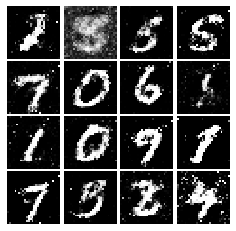


Iter: 4000, D: 1.351, G:0.8596


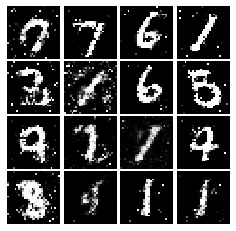


EPOCH:  10
Iter: 4250, D: 1.269, G:0.9001


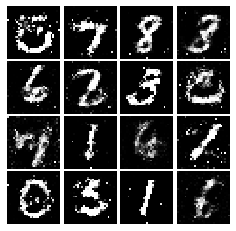


Iter: 4500, D: 1.21, G:1.027


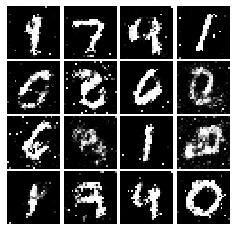

In [8]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

EPOCH:  1
Iter: 0, D: 0.3797, G:0.5153


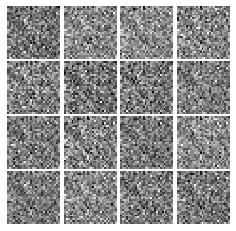


Iter: 250, D: 0.2699, G:0.5779


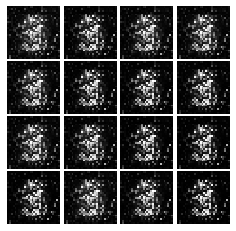


EPOCH:  2
Iter: 500, D: 0.1272, G:1.1


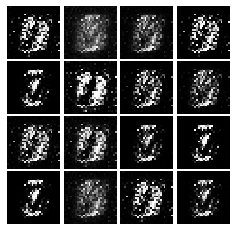


Iter: 750, D: 0.1311, G:0.437


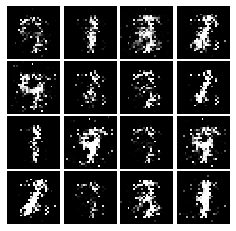


EPOCH:  3
Iter: 1000, D: 0.1547, G:0.2489


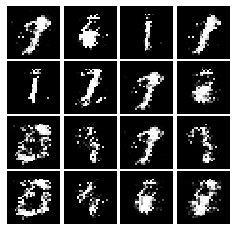


Iter: 1250, D: 0.1787, G:0.3135


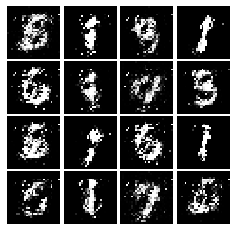


EPOCH:  4
Iter: 1500, D: 0.1406, G:0.3151


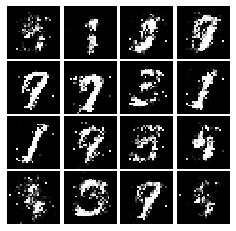


Iter: 1750, D: 0.1893, G:0.1831


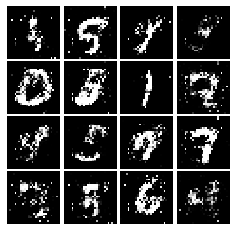


EPOCH:  5
Iter: 2000, D: 0.1852, G:0.1777


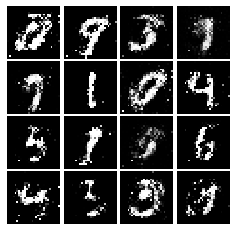


Iter: 2250, D: 0.207, G:0.1858


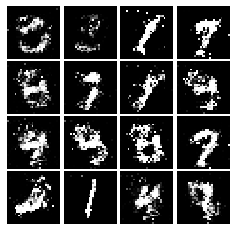


EPOCH:  6
Iter: 2500, D: 0.1972, G:0.17


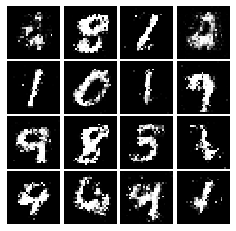


Iter: 2750, D: 0.2439, G:0.176


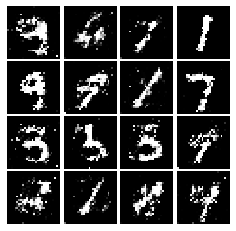


EPOCH:  7
Iter: 3000, D: 0.1942, G:0.1713


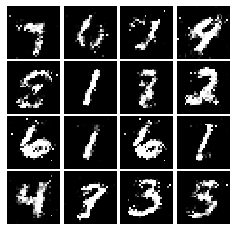


Iter: 3250, D: 0.1826, G:0.1997


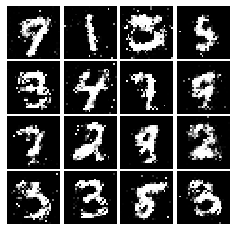


EPOCH:  8
Iter: 3500, D: 0.2377, G:0.1715


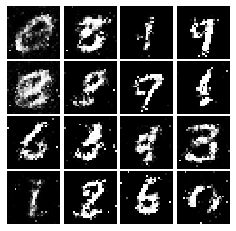


EPOCH:  9
Iter: 3750, D: 0.215, G:0.1649


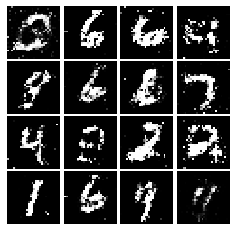


Iter: 4000, D: 0.2477, G:0.1603


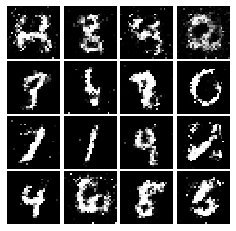


EPOCH:  10
Iter: 4250, D: 0.2118, G:0.1812


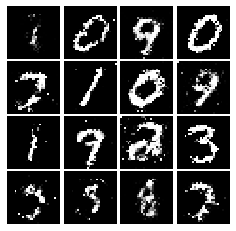


Iter: 4500, D: 0.2312, G:0.1714


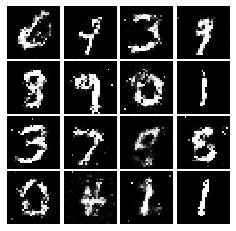

In [9]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)